# Deep Ensemble for uncertainty estimation - classification example

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")
    
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from src.train_test import fit_class, fit_ensemble, \
    fit_ensemble, test_class, test_class_ensemble
from src.model import MLP, DeepEnsembleClassification
from src.evaluate import evaluate_class
from utils import data_loaders
from utils.domain_split import hyperplane_split
from utils.plotting import plot_train

seed = np.random.randint(10000)
seed = 3353 #3408
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I have specifically chosen this seed to produce a good domain split.

### Diabetes dataset

In [2]:
df = pd.read_csv('data/classification/diabetes.csv')
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


## Load data, split domain, train/test, etc...

In [3]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)
df[dom_idx].head()

# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_classes = len(set(y))
n_features = X.shape[1]
n_epochs = 1000
n_hidden_1 = 100
n_hidden_2 = 30
n_hidden_3 = None
learning_rate = 1e-3
weight_decay = 1e-4
batch_size_train = 64
batch_size_test = 64

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)

Found random direction n = [-0.46735987 -0.11818246 -0.23838448  0.10092845 -0.16384983 -0.05739857
 -0.49232007 -0.6341792   0.16090456]
Found split with ratio r = 0.20078226857887874


### Train a standard MLP for classification

In [4]:
model = MLP(n_features, n_classes, [n_hidden_1, n_hidden_2, ], 'tanh').to(device)
loss_function = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=10*1e-4, weight_decay=weight_decay)

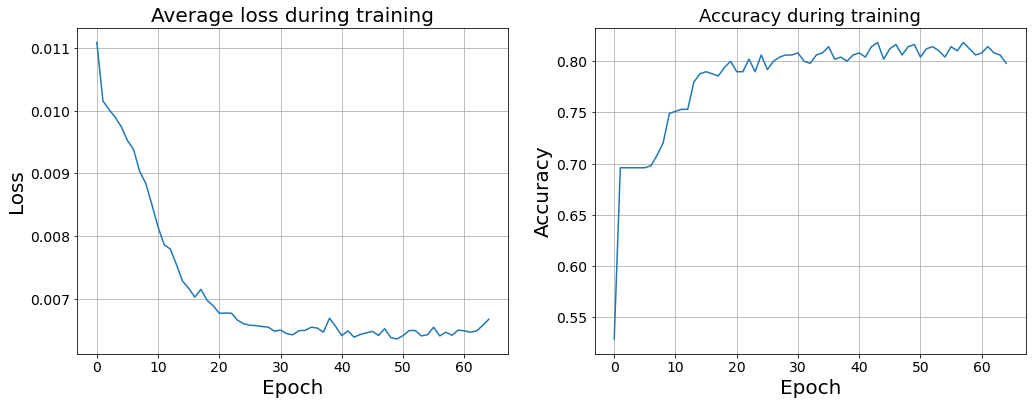

In [5]:
# Train the model
train_losses, accs = fit_class(model, loss_function, optimizer, train_loader, n_epochs=100,
               verbose=0, early_stopping='train', return_losses=True, return_acc=True)

plot_train(train_losses, accs)

In [6]:
print("Train:")
test_class(model, loss_function, train_loader)
print("Test:")
test_class(model, loss_function, test_loader)
print("OOD:")
test_class(model, loss_function, OOD_loader)

Train:
Accuracy: 393/490 = 80.2040786743164%
Test:
Accuracy: 95/123 = 77.23577117919922%
OOD:
Accuracy: 91/154 = 59.09090805053711%


In [7]:
model.name = 'Singleton MLP ensemble' # hack to use evaluate_class with a single model

train_evaluation = evaluate_class(
    model=model, 
    loader=train_loader, 
    dataset='Diabetes, Train data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate_class(
    model=model, 
    loader=test_loader, 
    dataset='Diabetes, Test data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate_class(
    model=model, 
    loader=OOD_loader, 
    dataset='Diabetes, OOD data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)


print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Singleton MLP ensemble
Evaluated on: Diabetes, Train data
Number of posterior samples: NA
Average NLPD: -0.7474114895
Average accuracy: 0.8020408154
Average AUROC: 0.8832490444
Average ECE: 0.050330922

Test evaluation:
Inference type: Singleton MLP ensemble
Evaluated on: Diabetes, Test data
Number of posterior samples: NA
Average NLPD: -0.7134664059
Average accuracy: 0.7723577023
Average AUROC: 0.7970918417
Average ECE: 0.1341613531

OOD evaluation:
Inference type: Singleton MLP ensemble
Evaluated on: Diabetes, OOD data
Number of posterior samples: NA
Average NLPD: -0.5955554843
Average accuracy: 0.5909090638
Average AUROC: 0.7582658529
Average ECE: 0.2174773216


### Ensemble of 30 MLPs

In [8]:
model = MLP(n_features, n_classes, [n_hidden_1, n_hidden_2, ], 'tanh').to(device)
loss_function = nn.CrossEntropyLoss()

In [9]:
M = 30
ensemble = fit_ensemble(model, loss_function, lr=learning_rate, M=M, plot=False,
                  loader=train_loader, n_epochs=n_epochs, early_stopping='train',
                   verbose=0)

In [10]:
# Turn this into a DeepEnsembleClassification object
ensemble = DeepEnsembleClassification(ensemble)

# Now it has a name and a device :)
ensemble.name, ensemble.device

('Deep Ensemble Classification (30 models)', device(type='cuda', index=0))

In [11]:
train_evaluation = evaluate_class(
    model=ensemble, 
    loader=train_loader, 
    dataset='Diabetes, Train data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate_class(
    model=ensemble, 
    loader=test_loader, 
    dataset='Diabetes, Test data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate_class(
    model=ensemble, 
    loader=OOD_loader, 
    dataset='Diabetes, OOD data', 
    posterior_samples = 'NA', 
    num_classes=n_classes, 
    device=device,
    rounded=10)


print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items() 

Train evaluation:
Inference type: Deep Ensemble (30 models)
Evaluated on: Diabetes, Train data
Number of posterior samples: NA
Average NLPD: -0.7496958375
Average accuracy: 0.8163265586
Average AUROC: 0.884016633
Average ECE: 0.0400566459

Test evaluation:
Inference type: Deep Ensemble (30 models)
Evaluated on: Diabetes, Test data
Number of posterior samples: NA
Average NLPD: -0.7137570381
Average accuracy: 0.7723577023
Average AUROC: 0.7987442017
Average ECE: 0.1181728989

OOD evaluation:
Inference type: Deep Ensemble (30 models)
Evaluated on: Diabetes, OOD data
Number of posterior samples: NA
Average NLPD: -0.5961303711
Average accuracy: 0.584415555
Average AUROC: 0.7560728788
Average ECE: 0.227949053
